# Построение событий 2013 г для статьи

In [1]:
!date
!pwd
!ls ./data

Вт дек 19 19:06:06 MSK 2017
/home/sphere/github/Sphere/Data2013


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

In [13]:
# считать данные, заменив 0 на NaN
na_values = ['NO CLUE', 'N/A', '0']
datum11588 = pd.read_csv('./data/11588.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11589 = pd.read_csv('./data/11589.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11308 = pd.read_csv('./data/11308.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum11452 = pd.read_csv('./data/11452.work.csv', na_values=na_values, header = None, index_col=False, sep=',')
datum12114 = pd.read_csv('./data/12114.work.csv', na_values=na_values, header = None, index_col=False, sep=',')

# убрать последние три канала
param = [i for i in range(109)]
datum11588 = datum11588[param]
datum11589 = datum11589[param]
datum11308 = datum11308[param]
datum11452 = datum11452[param]
datum12114 = datum12114[param]

# отрицательные значения заменить на маленькое положительное 0.001
# маленькие значения (< minshow) заменить на маленькое положительное minpos = 0.0001
minshow = 0.01
minpos = 0.0001
data = [datum11588, datum11589,datum11308, datum11452, datum12114]
for datum in data:
    for i in range(datum.shape[1]):
        zero_cell = datum[i] <= minshow
        datum.loc[zero_cell, i] = minpos
    datum.fillna(0.001, inplace = True)

frame = [datum11588, datum11589,datum11308, datum11452, datum12114]    
datum11588.shape    

(970, 109)

In [3]:
plt.rcParams['figure.figsize'] =(12,6)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

In [4]:
title = ['11588', '11589','11308','11452', '12114']

### Frames before calibration and time drift corrections

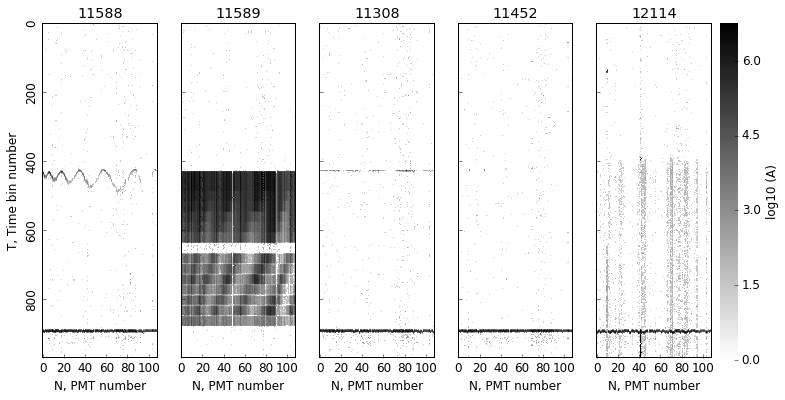

In [5]:
colorscale = "gist_yarg"
#colorscale = "BuGn" #cool"

fig, axn = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,6))
cbar_ax  = fig.add_axes([.91, .12, .02, .78])
cbar_kws = {"label":'log10 (A)'}
cbar = False
xt, yt = 0, 0
xb, yb = 108, 969

for (i, ax), datum in zip(enumerate(axn.flat), frame):
    sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                cbar=i == 0,
                vmin=0, 
                xticklabels=20, yticklabels=200,
                cbar_ax  = None if i else cbar_ax,
                cbar_kws = None if i else cbar_kws
               )
    ax.plot(( xt, xt),( yt, yb),'k')
    ax.plot(( xt, xb),( yb, yb),'k')
    ax.plot(( xb, xb),( yb, yt),'k')
    ax.plot(( xt, xb),( yt, yt),'k')
    #ax.axhline(y=427,linewidth=1, color='r') 
    ax.set_title(title[i])
    ax.set_xlabel('N, PMT number')
    if i == 0:
        ax.set_ylabel('T, Time bin number')
#'''
#if colorscale == "gist_yarg":
#    plt.savefig('frames_bw.pdf', bbox_inches='tight')
#else:    
#    plt.savefig('frames_col_bugn.pdf', bbox_inches='tight')
    #plt.savefig('frames_col.eps', bbox_inches='tight')
#'''

### Time Drift correction

In [6]:
### считаем сдвиг в каналах ###
shift = []
for fr in range(len(frame)):
    tmin, tmax = 850, 930 
    if fr == 1:
        tmin, tmax = 400,487
    cumsum1 = frame[fr][tmin:tmax].cumsum()
    half = cumsum1[:][len(cumsum1)-1:len(cumsum1)]/2
    idx = []
    for i in range(109):
        idx.append(cumsum1[i][cumsum1[i] > float(half[i])].index.min())
    idx = pd.DataFrame(idx)
    shi = idx - int(idx.mean())
    shift.append(list(shi[0]))
print(shift[0])

[3, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
### производим сдвиг в каналах ###
minpos = 0.00001
dim = frame[0].shape[0]
print(dim)
nframe = []

for fr in range(len(frame)):
    oldframe = frame[fr][:]
    newframe = oldframe[:]
    print('fr=',fr)
    for chan in range(109):
        drift = shift[fr][chan]
        if drift > 0:
            for i in range(dim - drift):
                #if fr == 1 and chan == 78 : print('chan=',chan, drift, i, i + drift)
                newframe.loc[i, chan] = oldframe[chan][i + drift]
            for i in range(dim - drift, dim):
                newframe.loc[i, chan] = minpos
        if drift < 0:
            drift *= -1
            for i in range(dim-1, drift-1, -1):
                newframe.loc[i, chan] = oldframe[chan][i - drift]
            for i in range(0,drift):
                newframe.loc[i, chan] = minpos
    nframe.append(newframe)

970
fr= 0
fr= 1
fr= 2
fr= 3
fr= 4


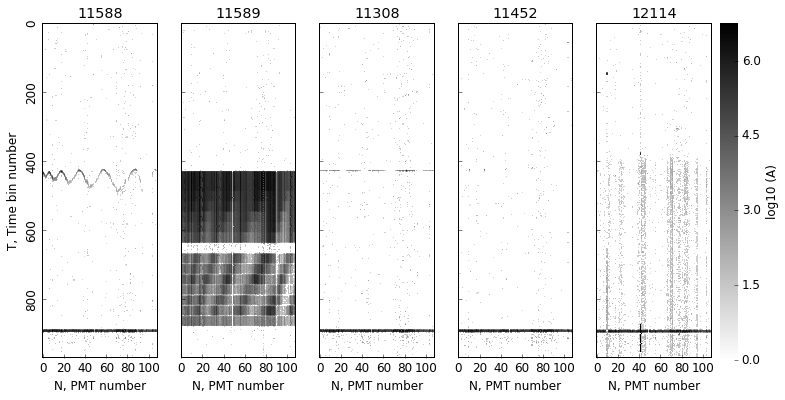

In [13]:
# control of time drift correction
colorscale = "gist_yarg"
fig, axn = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,6))
cbar_ax  = fig.add_axes([.91, .12, .02, .78])
cbar_kws = {"label":'log10 (A)'}
cbar = False
xt, yt = 0, 0
xb, yb = 108, 969

for (i, ax), datum in zip(enumerate(axn.flat), frame):
    sns.heatmap(np.log(datum), ax=ax, cmap = colorscale,
                cbar=i == 0,
                vmin=0, 
                xticklabels=20, yticklabels=200,
                cbar_ax  = None if i else cbar_ax,
                cbar_kws = None if i else cbar_kws
               )
    ax.plot(( xt, xt),( yt, yb),'k')
    ax.plot(( xt, xb),( yb, yb),'k')
    ax.plot(( xb, xb),( yb, yt),'k')
    ax.plot(( xt, xb),( yt, yt),'k')
    #ax.axhline(y=427,linewidth=1, color='r') 
    ax.set_title(title[i])
    ax.set_xlabel('N, PMT number')
    if i == 0:
        ax.set_ylabel('T, Time bin number')

In [35]:
data = [[88, 36, 18, 19,  7,  1, 20,  8, 43], # 11588
        [88, 36, 18, 19,  7,  1, 20,  8, 43], # 11589
        [53, 54, 81, 82, 83,  0, 73],         # 11308
        [10, 11, 25, 45, 46, 70, 78],         # 11452
        [72, 71, 45, 70, 45, 46, 24]]         # 12114
axmin = [415, 415, 415, 405, 300]
axmax = [480, 891, 480, 465, 891] 
aylim = [(0,370), (0,850), (0), (0,57), (0,24)]
dd = len(title)

C:\Program Files\Anaconda\lib\site-packages\matplotlib\gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


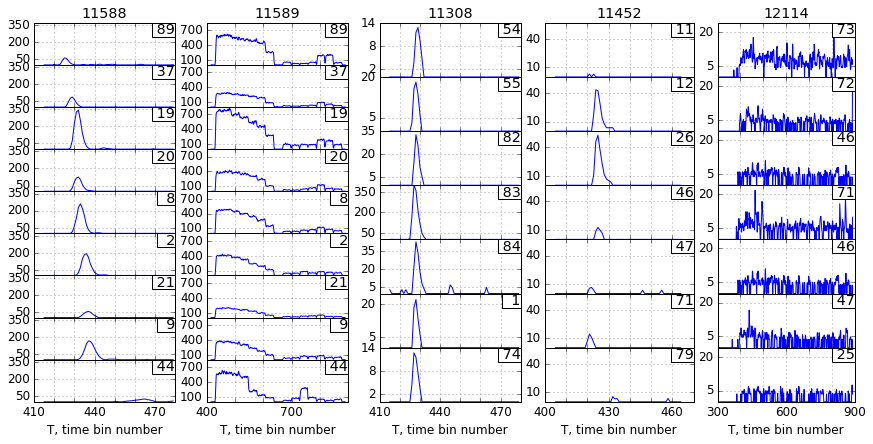

In [19]:
frame = [datum11588, datum11589, datum11308, datum11452, datum12114]

######### plot frames #################
fig = plt.figure(figsize=(12,6))
gs = []
#gs = [gridspec.GridSpec(len(data[num]), 1) for num in range(dd)]

dd = len(frame)
for num in range(dd):
    gscur = gridspec.GridSpec(len(data[num]), 1)
    xmin = axmin[num]
    xmax = axmax[num]
    plt.rcParams['font.size'] = 0
    for i, n in enumerate(data[num]):
        ax = fig.add_subplot(gscur[i])
        ax.plot(frame[num][n][xmin:xmax], label = " %2s" % (str(n+1)) )
        plt.ylim(aylim[num])
        plt.xlim(xmin,xmax)
        plt.legend()
        plt.grid() 
        if i == 0:
            ax.set_title(title[num])
            locsx, labsx = plt.xticks() 
        ### axis ticks ###
        locsy, labsy = plt.yticks() 
        plt.yticks(locsy[1::3]) 
        xlab = []
        if i == len(data[num])-1:
            for i,n in enumerate(locsx):
                if i%3 != 0:
                    xlab.append("")
                else:
                    xlab.append(str(int(n)) )
        plt.xticks(locsx, xlab)    
            #plt.xticks(locsx[:])
        #ax.axes.xaxis.set_ticks(locsx)
        #ax.axes.xaxis.set_ticklabels(xlab)

    plt.rcParams['font.size'] = 12
    ax.set_xlabel('T, time bin number')

    # tight_layout
    gscur.tight_layout(fig, rect=[num/dd, 0, (num+1)/dd, 1], pad = 0.2)
    gs.append(gscur)

########################
top    = min(x.top    for x in gs)
bottom = max(x.bottom for x in gs)
for gscur in gs:
    gscur.update(top=top, bottom=bottom, hspace = 0.0)
#plt.savefig('pulses.png', bbox_inches='tight')

C:\Program Files\Anaconda\lib\site-packages\matplotlib\gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


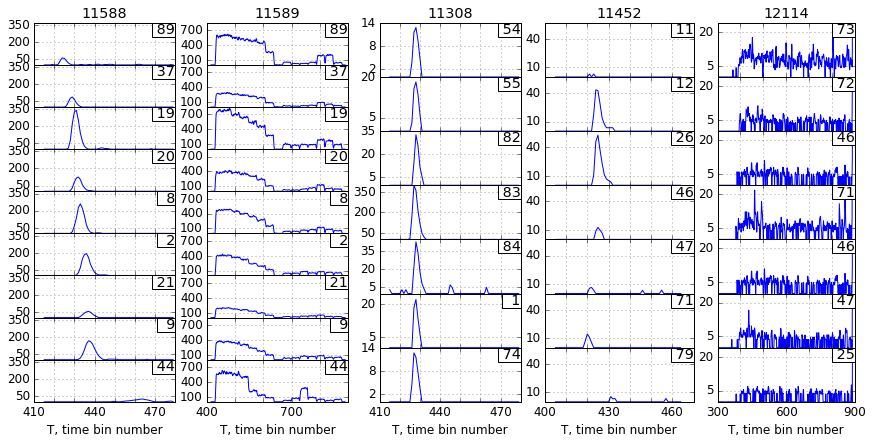

In [9]:
######### plot new shifted frames #################
fig = plt.figure(figsize=(12,6))
gs = []
for num in range(dd):
    gscur = gridspec.GridSpec(len(data[num]), 1)
    xmin = axmin[num]
    xmax = axmax[num]
    plt.rcParams['font.size'] = 0
    
    for i, n in enumerate(data[num]):
        ax = fig.add_subplot(gscur[i])
        ax.plot(nframe[num][n][xmin:xmax], label = " %2s" % (str(n+1)) )
        plt.ylim(aylim[num])
        plt.xlim(xmin,xmax)
        plt.legend()
        if i == 0:
            ax.set_title(title[num])
            locsx, labsx = plt.xticks() 
        ### axis ticks ###
        locsy, labsy = plt.yticks() 
        plt.yticks(locsy[1::3]) 
        xlab = []
        if i == len(data[num])-1:
            for i,n in enumerate(locsx):
                if i%3 != 0:
                    xlab.append("")
                else:
                    xlab.append(str(int(n)) )
        plt.xticks(locsx, xlab)    
        plt.grid() 
        
    plt.rcParams['font.size'] = 12
    ax.set_xlabel('T, time bin number')

    # tight_layout
    gscur.tight_layout(fig, rect=[num/dd, 0, (num+1)/dd, 1], pad = 0.2)
    gs.append(gscur)

########################
top    = min(x.top    for x in gs)
bottom = max(x.bottom for x in gs)
for gscur in gs:
    gscur.update(top=top, bottom=bottom, hspace = 0.0)
#plt.savefig('pulses.png', bbox_inches='tight')

### Retina integral sum signal

In [6]:
from matplotlib import colors

import retina
x=retina.x
y=retina.y
C=retina.C
N=retina.N

xmin = min(x)-3
xmax = max(x)+3
ymin = min(y)-1
ymax = max(y)+1

In [14]:
sum11588 = datum11588[400:500].sum()
sum11589 = datum11589[400:950].sum()
sum11308 = datum11308[400:500].sum()
sum11452 = datum11452[400:500].sum()
sum12114 = datum12114[400:850].sum()
suma  = [sum11588, sum11589,sum11308, sum11452, sum12114]

In [15]:
# считать калибровки из файлов
caldim = [] # dima calibration
for i in range(len(title)):
    name = './data/cal/pyro/'+title[i]+'.cal.csv'
    #print(name)
    cali = pd.read_csv(name, header = None, index_col=False, sep=',')
    caldim.append(cali)
caltim = [] # timur calibration
for i in range(len(title)):
    name = './data/cal/timur/'+title[i]+'.cal.csv'
    #print(name)
    cali = pd.read_csv(name, header = None, index_col=False, sep=',')
    caltim.append(cali)

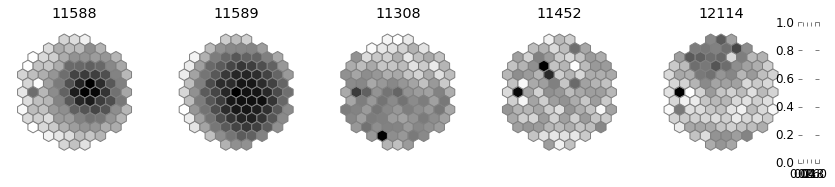

In [16]:
nn=5
fig, axn = plt.subplots(1, nn, sharex=True, sharey=True, figsize=(14,2.5))
plt.rcParams['axes.linewidth'] = 0.0
#plt.rcParams['font.size'] = 12
cbar_ax  = fig.add_axes([.91, .12, .02, .78])
cbar_kws = {"label":'log10 (A)'}

for i in range(nn):
    axn[i].axis([xmin, xmax, ymin, ymax])
    axn[i].axes.get_xaxis().set_visible(False)
    axn[i].axes.get_yaxis().set_visible(False)
    axn[i].set_title(title[i]) 
    
    amp = []
    for ch in range(109):
        #amp.append( suma[i][N[ch]-1]*caldim[i][N[ch]-1] )
        amp.append( suma[i][N[ch]-1]*caltim[i][N[ch]-1] )
        
    hb = axn[i].hexbin(x, y, C=np.log(amp),gridsize=(10,6), 
                       cmap="gist_yarg", edgecolor='gray',                
                #cbar_ax  = None if i else cbar_ax,
                #cbar_kws = None if i else cbar_kws
                )


In [10]:
suma[2][73]*caldim[2][73]

0    30.457867
Name: 73, dtype: float64

In [11]:
suma[2][82]*caldim[2][82]

0    614.320178
Name: 82, dtype: float64

In [12]:
suma[2][73], suma[2][82]

(39.889500000000233, 1328.4091999999982)

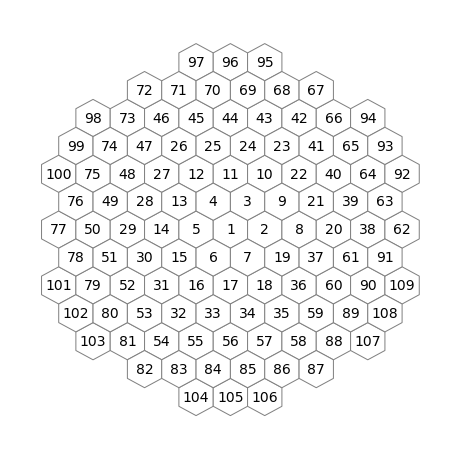

In [29]:
# выполнить ДВА раза, чтобы линии исчезли
fig = plt.figure(figsize=(8,8))
cmap = colors.ListedColormap(['white', 'yellow', 'orange'])
ax2 = plt.subplot()
hb = ax2.hexbin(x, y, C,gridsize=(10,6), cmap=cmap, edgecolor='gray' )
for i in range(109):
    plt.text(x[i], y[i], str(N[i]), ha='center', va='center')

ax2.axis([xmin, xmax, ymin, ymax])
#cur_axes = plt.gca()
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['font.size'] = 14

#fig.show()
plt.savefig('retina.eps',  bbox_inches='tight') #, figsize=(6,6), edgecolor = 'red')
plt.savefig('retina.png',  bbox_inches='tight') #, dpi=fig.dpi, format = 'png',figsize=(10,10))

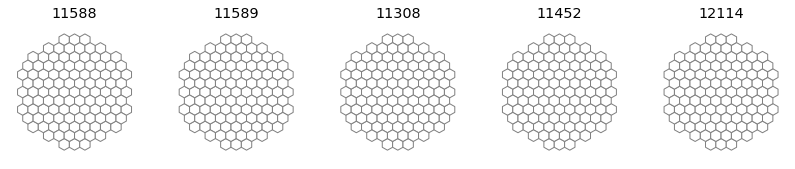

In [59]:
data  = [datum11588, datum11589,datum11308, datum11452, datum12114]
title = ['11588', '11589','11308','11452', '12114']
nn=5
fig, axn = plt.subplots(1, nn, sharex=True, sharey=True, figsize=(14,2.5))
cmap = colors.ListedColormap(['white', 'yellow', 'orange'])
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['font.size'] = 12

#for (i, ax), datum in zip(enumerate(axn.flat), data):
for i in range(nn):
    hb = axn[i].hexbin(x, y, C,gridsize=(10,6), cmap=cmap, edgecolor='gray' )
    axn[i].axis([xmin, xmax, ymin, ymax])
    axn[i].axes.get_xaxis().set_visible(False)
    axn[i].axes.get_yaxis().set_visible(False)
    axn[i].set_title(title[i])


In [68]:
sum11588 = datum11588[400:500].sum()
sum11589 = datum11589[400:950].sum()
sum11308 = datum11308[400:500].sum()
sum11452 = datum11452[400:500].sum()
sum12114 = datum12114[400:500].sum()

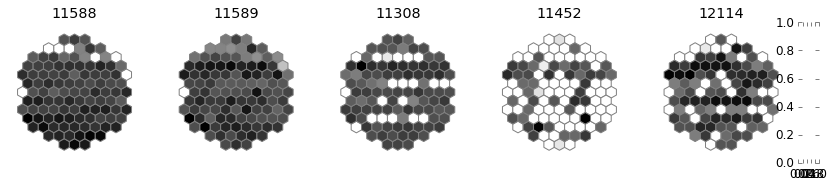

In [77]:
data  = [datum11588, datum11589,datum11308, datum11452, datum12114]
suma  = [sum11588, sum11589,sum11308, sum11452, sum12114]
title = ['11588', '11589','11308','11452', '12114']

nn=5
fig, axn = plt.subplots(1, nn, sharex=True, sharey=True, figsize=(14,2.5))
cmap = colors.ListedColormap(['white', 'yellow', 'orange'])
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['font.size'] = 12
cbar_ax  = fig.add_axes([.91, .12, .02, .78])
cbar_kws = {"label":'log10 (A)'}
#cbar = False

#for (i, ax), datum in zip(enumerate(axn.flat), data):
for i in range(nn):
    hb = axn[i].hexbin(x, y, C=np.log(suma[i]),gridsize=(10,6), cmap="gist_yarg", edgecolor='gray',                
                #cbar_ax  = None if i else cbar_ax,
                #cbar_kws = None if i else cbar_kws
                )
    axn[i].axis([xmin, xmax, ymin, ymax])
    axn[i].axes.get_xaxis().set_visible(False)
    axn[i].axes.get_yaxis().set_visible(False)
    axn[i].set_title(title[i])
    

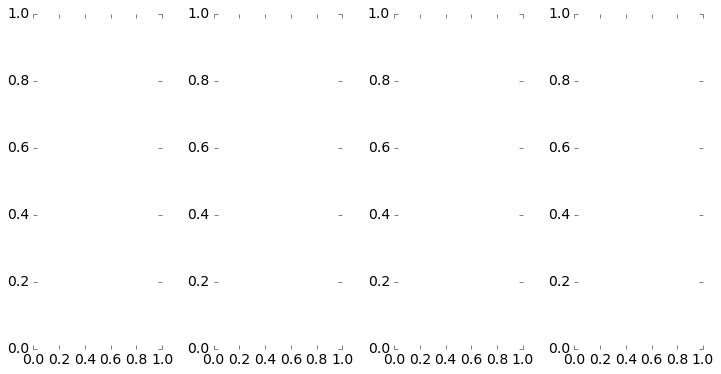

In [34]:
grid = plt.GridSpec(7, 4, wspace=0.4, hspace=0.3)
plt.subplot(grid[:, 0])
plt.subplot(grid[:, 1])
plt.subplot(grid[:, 2])
plt.subplot(grid[:, 3]);

In [74]:
help(axn[i].hexbin)

Help on method hexbin in module matplotlib.axes._axes:

hexbin(x, y, C=None, gridsize=100, bins=None, xscale='linear', yscale='linear', extent=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors='none', reduce_C_function=<function mean at 0x0000000004C96488>, mincnt=None, marginals=False, *, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Make a hexagonal binning plot.
    
    Call signature::
    
       hexbin(x, y, C = None, gridsize = 100, bins = None,
              xscale = 'linear', yscale = 'linear',
              cmap=None, norm=None, vmin=None, vmax=None,
              alpha=None, linewidths=None, edgecolors='none'
              reduce_C_function = np.mean, mincnt=None, marginals=True
              **kwargs)
    
    Make a hexagonal binning plot of *x* versus *y*, where *x*,
    *y* are 1-D sequences of the same length, *N*. If *C* is *None*
    (the default), this is a histogram of the number of occuren